# Predicting Flu Vaccine Compliance

## Overview

The CDC has provided the National 2009 H1N1 Flu Survey Data for the purposes of building a model that can predict who will and won't get the flu vaccine. They want to pull out the most useful features from this model in order to later build other predictive models that can predict compliance with COVID-19 vaccines, as Covid boosters are routine, like the seasonal flu vaccines. 

### Buisness Problem

Creating a model to pull out features that best predict who will get the seasonal flu vaccine. 

### Dataset Size 

The initial dataset was 26,707 rows with 36 columns. After initial data cleaning there were 27 columns. 

### Limitations of the Dataset

The data was collected via telephone surveys, a commonly used polling method which is not representative or random (as people choose to respond or not when they are called). Additionally, today new models may need to take into account the anti-vaccine movement (article [here](https://pubmed.ncbi.nlm.nih.gov/16039769/)) which was not as prevalent when the data was collected in 2009, as well as the cultural and behavioral shifts that have occured due Covid-19.


### Why We Used This Dataset

Despite the above limitations, the dataset does contain a large number of responses on and takes into account a large number of features relevant to the seasonal flu vaccine compliance, and is a relatively recent dataset. For all these reasons, we decided to use this dataset to create our predictive model. 


## Looking at the Data

### Imports

In [1]:
# imports
import numpy as np
import pandas as pd
import statistics
import scipy.sparse
import xgboost
import matplotlib.pyplot as plt

#import warnings
#warnings.filterwarnings('ignore')

from scipy.stats import chi2_contingency

from xgboost import XGBClassifier
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report




### Data: Initial Look

In [2]:
features = pd.read_csv("Data/training_set_features.csv")
labels = pd.read_csv("Data/training_set_labels.csv")

In [3]:
#checking if the features and lable dataframes match up 
np.testing.assert_array_equal(features.index.values, labels.index.values)

In [4]:
#lets look at the features data
features.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


In [5]:
# Now lets look into the labels data
labels.head()


,respondent_id,h1n1_vaccine,seasonal_vaccine
0,0,0,0
1,1,0,1
2,2,0,0
3,3,0,1
4,4,0,0


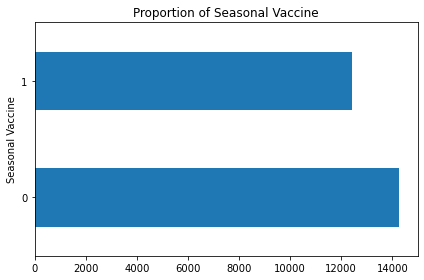

In [6]:
# small bar graph comparing who recieved the vaccine and who didn't
fig, ax = plt.subplots()
labels['seasonal_vaccine'].value_counts().plot.barh(title="Proportion of Seasonal Vaccine")
ax.set_ylabel("Seasonal Vaccine")
fig.tight_layout()

#### Description of Features

In [7]:
# Looking into the `features` DataFrame
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   h1n1_concern                 26615 non-null  float64
 2   h1n1_knowledge               26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_h1n1             24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        25736 non-null  float64
 13  child_under_6_mo

Descriptions of the features (taken from [here](https://www.drivendata.org/competitions/66/flu-shot-learning/page/211/)): 

For all binary variables: 0 = No; 1 = Yes.

- h1n1_concern - Level of concern about the H1N1 flu. 0 = Not at all concerned; 1 = Not very concerned; 2 = Somewhat concerned; 3 = Very concerned.
- h1n1_knowledge - Level of knowledge about H1N1 flu. 0 = No knowledge; 1 = A little knowledge; 2 = A lot of knowledge.
- behavioral_antiviral_meds - Has taken antiviral medications. (binary)
- behavioral_avoidance - Has avoided close contact with others with flu-like symptoms. (binary)
- behavioral_face_mask - Has bought a face mask. (binary)
- behavioral_wash_hands - Has frequently washed hands or used hand sanitizer. (binary)
- behavioral_large_gatherings - Has reduced time at large gatherings. (binary)
- behavioral_outside_home - Has reduced contact with people outside of own household. (binary)
- behavioral_touch_face - Has avoided touching eyes, nose, or mouth. (binary)
- doctor_recc_h1n1 - H1N1 flu vaccine was recommended by doctor. (binary)
- doctor_recc_seasonal - Seasonal flu vaccine was recommended by doctor. (binary)
- chronic_med_condition - Has any of the following chronic medical conditions: asthma or an other lung condition, diabetes, a heart condition, a kidney condition, sickle cell anemia or other anemia, a neurological or neuromuscular condition, a liver condition, or a weakened immune system caused by a chronic illness or by medicines taken for a chronic illness. (binary)
- child_under_6_months - Has regular close contact with a child under the age of six months. (binary)
- health_worker - Is a healthcare worker. (binary)
- health_insurance - Has health insurance. (binary)
- opinion_h1n1_vacc_effective - Respondent's opinion about H1N1 vaccine effectiveness. 1 = Not at all effective; 2 = Not very effective; 3 = Don't know; 4 = Somewhat effective; 5 = Very effective.
- opinion_h1n1_risk - Respondent's opinion about risk of getting sick with H1N1 flu without vaccine.1 = Very Low; 2 = Somewhat low; 3 = Don't know; 4 = Somewhat high; 5 = Very high.
- opinion_h1n1_sick_from_vacc - Respondent's worry of getting sick from taking H1N1 vaccine.1 = Not at all worried; 2 = Not very worried; 3 = Don't know; 4 = Somewhat worried; 5 = Very worried.
- opinion_seas_vacc_effective - Respondent's opinion about seasonal flu vaccine effectiveness.1 = Not at all effective; 2 = Not very effective; 3 = Don't know; 4 = Somewhat effective; 5 = Very effective.
- opinion_seas_risk - Respondent's opinion about risk of getting sick with seasonal flu without vaccine.1 = Very Low; 2 = Somewhat low; 3 = Don't know; 4 = Somewhat high; 5 = Very high.
- opinion_seas_sick_from_vacc - Respondent's worry of getting sick from taking seasonal flu vaccine.1 = Not at all worried; 2 = Not very worried; 3 = Don't know; 4 = Somewhat worried; 5 = Very worried.
- age_group - Age group of respondent.
- education - Self-reported education level.
- race - Race of respondent.
- sex - Sex of respondent.
- income_poverty - Household annual income of respondent with respect to 2008 Census poverty thresholds.
- marital_status - Marital status of respondent.
- rent_or_own - Housing situation of respondent.
- employment_status - Employment status of respondent.
- hhs_geo_region - Respondent's residence using a 10-region geographic classification defined by the U.S. Dept. of Health and Human Services. Values are represented as short random character strings.
- census_msa - Respondent's residence within metropolitan statistical areas (MSA) as defined by the U.S. Census.
- household_adults - Number of other adults in household, top-coded to 3.
- household_children - Number of children in household, top-coded to 3.
- employment_industry - Type of industry respondent is employed in. Values are represented as short random character strings.
- employment_occupation - Type of occupation of respondent. Values are represented as short random character strings.

### Data: Initial Cleaning

Let's remove all of the columns related to only the H1N1 vaccine: h1n1_concern, h1n1_knowledge, doctor_recc_h1n1, opinion_h1n1_vacc_effective, opinion_h1n1_risk, opinion_h1n1_sick_from_vacc

Additionally, there are some columns where the information has been scrambled (presumably to protect the respondents personal information) so lets remove those as well as we can't extract any useful information without knowing what they are coded for: hhs_geo_region, employment_industry, employment_occupation

Finally, let's remove 'h1n1_vaccine' and 'respondent_id' from the labels DataFrame, and then turn the labels dataframe into an array so we can use it when we build our models later on. 

In [8]:
features.drop(['respondent_id', 'h1n1_concern', 'h1n1_knowledge', 'doctor_recc_h1n1',
               'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 
               'opinion_h1n1_sick_from_vacc', 'hhs_geo_region', 
               'employment_industry', 'employment_occupation','health_insurance'],
              axis = 1, inplace = True)

labels.drop(['h1n1_vaccine', 'respondent_id'], axis = 1, inplace= True)
labels = np.ravel(labels, order = 'C')

In [9]:
# train_test_split()
X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state = 42)

## Creating Preprocessing Pipeline

In order to create a pipeline for preprocessing, let's first figure out how we will handle our missing values.

In [10]:
features.isnull().sum()

behavioral_antiviral_meds        71
behavioral_avoidance            208
behavioral_face_mask             19
behavioral_wash_hands            42
behavioral_large_gatherings      87
behavioral_outside_home          82
behavioral_touch_face           128
doctor_recc_seasonal           2160
chronic_med_condition           971
child_under_6_months            820
health_worker                   804
opinion_seas_vacc_effective     462
opinion_seas_risk               514
opinion_seas_sick_from_vacc     537
age_group                         0
education                      1407
race                              0
sex                               0
income_poverty                 4423
marital_status                 1408
rent_or_own                    2042
employment_status              1463
census_msa                        0
household_adults                249
household_children              249
dtype: int64

The largest amount of missing data is in `health_insurance` - let's look into the signifigance of that variable to see if we can drop it. 

In [11]:
# cross_tab = pd.crosstab(features['health_insurance'], labels, margins = True)
# print(cross_tab)
# chi2, p, dof, expected = chi2_contingency(cross_tab)
# print(chi2, p)

We see above a statistically significant p-value and a very high chi2 value. As such, I've decided to keep this feature. 

I've chosen to change all NaN's to 0, as in 2009 when the data was collected the Affordable Care Act had not been passed, so people were not required to have health insurance. I think that keeping the NaN's as 0's is better reflective of this time. 

As for the rest of the missing variables:

 - For the rest of the **binary data** let's also replace all of the missing data with 0's. 
 
 - For the opinion questions and family features (`household_adults` and `household_children`) which are numeric **ordinal and interval data** let's replace all the missing data with the median. Additionally, we will use `MinMaxScaler` to scale this data. Most of our data is binary, and `MinMaxScaler` will keep the scaled data in the range of 0-1, which is ideal in this case. 
 
 - Finally, for our **categorical data** let's use `OneHotEncoder` to create dummy categories
 
 We will put all of this into a pipeline, so we can test out different models!  


In [18]:
#create functions for preprocessing

# function to replace NaN's in the ordinal and interval data 
def replace_NAN_median(X_df):
    opinions = ['opinion_seas_vacc_effective', 'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'household_adults',
                'household_children']
    for column in opinions:
        X_df[column].replace(np.nan, X_df[column].median(), inplace = True)
    return X_df

# function to replace NaN's in the catagorical data     
def replace_NAN_mode(X_df):
    miss_cat_features = ['education', 'income_poverty', 'marital_status', 'rent_or_own', 'employment_status']
    for column in miss_cat_features:
        X_df[column].replace(np.nan, statistics.mode(X_df[column]), inplace = True)
    return X_df

# function to replace NaN's in the binary data                                
def replace_NAN_0(X_df):
    miss_binary = ['behavioral_antiviral_meds', 'behavioral_avoidance','behavioral_face_mask' ,
    'behavioral_wash_hands', 'behavioral_large_gatherings', 'behavioral_outside_home',
    'behavioral_touch_face', 'doctor_recc_seasonal', 'chronic_med_condition', 
    'child_under_6_months', 'health_worker']
    for column in miss_binary:
        X_df[column].replace(np.nan, 0, inplace = True)
    return X_df

In [19]:
# Instantiate transformers
NAN_median = FunctionTransformer(replace_NAN_median)
NAN_mode = FunctionTransformer(replace_NAN_mode)
NAN_0 = FunctionTransformer(replace_NAN_0)
col_transformer = ColumnTransformer(transformers= [
    ("scaler", MinMaxScaler(), ['opinion_seas_vacc_effective', 'opinion_seas_risk',
                                'opinion_seas_sick_from_vacc', 
                                'household_adults', 'household_children']),
     
     # OHE catagorical string data
    ("ohe", OneHotEncoder(sparse = False, drop = "first"), ['age_group','education', 'race', 'sex', 
                                'income_poverty', 'marital_status', 'rent_or_own',
                                'employment_status', 'census_msa'])],
    verbose_feature_names_out = False,
    remainder="passthrough")



In [20]:
# Preprocessing Pipeline (Yey!)
preprocessing_pipe = Pipeline(steps=[
    ("NAN_median", NAN_median), 
    ("NAN_mode", NAN_mode),
    ("NAN_0", NAN_0),
    ("col_transformer", col_transformer)
    ])

## Modeling

### Create Baseline Model (LogisticRegression())

Because our outcome data is binary, let's try using `LogisticRegression` to model our data.

In [21]:
# Using our pipeline to instantiate the first model
logreg_base_model_pipe = Pipeline(steps=[("preprocessing_pipe", preprocessing_pipe),
                                    ("log_reg", LogisticRegression(random_state = 42))])
    

In [22]:
# fitting the model to our training data
logreg_base_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessing_pipe',
                 Pipeline(steps=[('NAN_median',
                                  FunctionTransformer(func=<function replace_NAN_median at 0x000001559F5B0DC0>)),
                                 ('NAN_mode',
                                  FunctionTransformer(func=<function replace_NAN_mode at 0x000001559F5B08B0>)),
                                 ('NAN_0',
                                  FunctionTransformer(func=<function replace_NAN_0 at 0x000001559F5B0B80>)),
                                 ('col_transformer',
                                  ColumnTransformer(rem...
                                                                   ['opinion_seas_vacc_effective',
                                                                    'opinion_seas_risk',
                                                                    'opinion_seas_sick_from_vacc',
                                                                    'household_adults',
  

In [23]:
# getting the mean accuracy of the model
logreg_base_model_pipe.score(X_train, y_train)


0.7750374438342487

### Optimized LogisticRegression() Model
In our baseline `LogisticRegression` model, we got .77% accuracy- pretty good. 

Lets see if changing the parameters `solver`, `penalty`(if we use L1 (Lasso) or L2 (Ridge), and `C` (how strong the regularization strength is with smaller values being *stronger* regularization) will improve our accuracy. 

We can check all these things at once using `GridSearchCV`

In [24]:
param_grid = {
    'log_reg__solver': ['liblinear'],
    'log_reg__penalty': ['l1', 'l2'], 
    'log_reg__C': [0.001,0.01,0.1,1,10,100,1000]   
}

gs = GridSearchCV(estimator=logreg_base_model_pipe,
                  param_grid=param_grid,
                  cv=5)


In [25]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing_pipe',
                                        Pipeline(steps=[('NAN_median',
                                                         FunctionTransformer(func=<function replace_NAN_median at 0x000001559F5B0DC0>)),
                                                        ('NAN_mode',
                                                         FunctionTransformer(func=<function replace_NAN_mode at 0x000001559F5B08B0>)),
                                                        ('NAN_0',
                                                         FunctionTransformer(func=<function replace_NAN_0 at 0x000001559F5B0B80>)),
                                                        ('col_transf...
                                                                                          OneHotEncoder(drop='first',
                                                                                                        sparse=False),


In [26]:
# Finding the parameters with the best results 
gs.best_params_

{'log_reg__C': 1, 'log_reg__penalty': 'l2', 'log_reg__solver': 'liblinear'}

In [27]:
# creating a new model with the optimized parameters
logreg_optimized_pipe = Pipeline(steps=[("preprocessing_pipe", preprocessing_pipe),
                                    ("log_reg", LogisticRegression(solver = 'liblinear', random_state = 42, C = 1, penalty= 'l2'))])
    

In [28]:
logreg_optimized_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessing_pipe',
                 Pipeline(steps=[('NAN_median',
                                  FunctionTransformer(func=<function replace_NAN_median at 0x000001559F5B0DC0>)),
                                 ('NAN_mode',
                                  FunctionTransformer(func=<function replace_NAN_mode at 0x000001559F5B08B0>)),
                                 ('NAN_0',
                                  FunctionTransformer(func=<function replace_NAN_0 at 0x000001559F5B0B80>)),
                                 ('col_transformer',
                                  ColumnTransformer(rem...
                                                                    'opinion_seas_sick_from_vacc',
                                                                    'household_adults',
                                                                    'household_children']),
                                                                  ('ohe',
                        

In [29]:
logreg_optimized_pipe.score(X_train, y_train)

0.7747878182725911

In [30]:
# code inspiration taken from: 
# https://stackoverflow.com/questions/38787612/how-to-extract-feature-importances-from-an-sklearn-pipeline
coefficients = logreg_optimized_pipe.steps[1][1].coef_

In [31]:
# https://stackoverflow.com/questions/54646709/sklearn-pipeline-get-feature-names-after-onehotencode-in-columntransformer
feature_names = list(logreg_optimized_pipe.named_steps["preprocessing_pipe"][3].get_feature_names_out())

In [32]:
# creating function so we can plot this and other model results
def plot_importance(feat_names, feat_importances, col1_name, col2_name, title):
    df = pd.concat([pd.DataFrame(feat_names), pd.DataFrame(np.transpose(feat_importances))], axis = 1)
    df.columns = [col1_name, col2_name]
    df_sorted = df.sort_values(by=col2_name, ascending=True, key = abs)
    
    plt.figure(figsize=(8,8))
    plt.barh(df_sorted[col1_name], df_sorted[col2_name], align='center') 
    plt.yticks(np.arange(len(df_sorted[col1_name])), df_sorted[col1_name]) 
    plt.xlabel(col2_name)
    plt.ylabel(col1_name)
    plt.title(title);

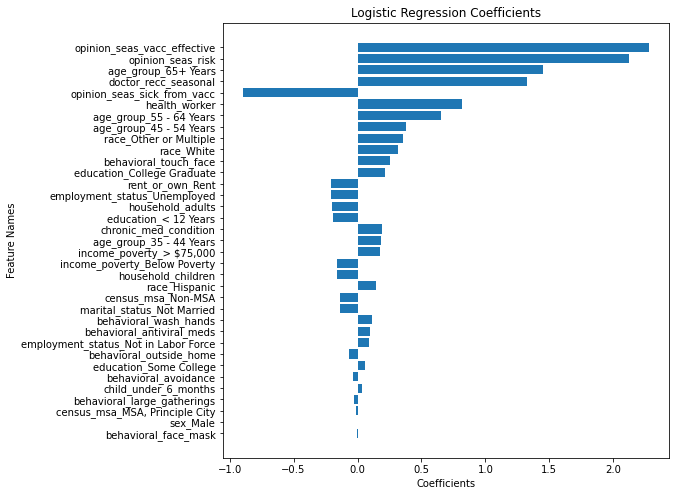

In [33]:
plot_importance(feature_names, coefficients, "Feature Names", "Coefficients",
               "Logistic Regression Coefficients")

### Building Baseline DecisionTreeClassifier model

In [34]:
# Using our pipeline to instantiate the first model
decision_tree_base_pipe = Pipeline(steps=[("preprocessing_pipe", preprocessing_pipe),
                                    ("base_decision_tree", DecisionTreeClassifier(random_state = 42))])
    

In [35]:
decision_tree_base_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessing_pipe',
                 Pipeline(steps=[('NAN_median',
                                  FunctionTransformer(func=<function replace_NAN_median at 0x000001559F5B0DC0>)),
                                 ('NAN_mode',
                                  FunctionTransformer(func=<function replace_NAN_mode at 0x000001559F5B08B0>)),
                                 ('NAN_0',
                                  FunctionTransformer(func=<function replace_NAN_0 at 0x000001559F5B0B80>)),
                                 ('col_transformer',
                                  ColumnTransformer(rem...
                                                                    'opinion_seas_risk',
                                                                    'opinion_seas_sick_from_vacc',
                                                                    'household_adults',
                                                                    'household_children']),
         

In [36]:
decision_tree_base_pipe.steps[1][1].feature_importances_


array([0.16220923, 0.0716188 , 0.04898228, 0.04537949, 0.0350649 ,
       0.01102603, 0.01434602, 0.01109111, 0.03200521, 0.01028596,
       0.02022644, 0.01946044, 0.01073372, 0.00923947, 0.0160905 ,
       0.03035727, 0.02354825, 0.01163582, 0.02437832, 0.02212779,
       0.02277151, 0.00671238, 0.02599534, 0.02369717, 0.00970171,
       0.02514961, 0.01195228, 0.01984371, 0.02809382, 0.02705374,
       0.02839391, 0.08993896, 0.02489319, 0.01161304, 0.01438257])

In [37]:
pred = decision_tree_base_pipe.predict(X_train)
print("training data:")
print(confusion_matrix(y_train, pred))
print(classification_report(y_train, pred))

pred_test = decision_tree_base_pipe.predict(X_test)
print("test data:")
print(confusion_matrix(y_test, pred_test))
print(classification_report(y_test, pred_test))


training data:
[[10636     2]
 [   67  9325]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     10638
           1       1.00      0.99      1.00      9392

    accuracy                           1.00     20030
   macro avg       1.00      1.00      1.00     20030
weighted avg       1.00      1.00      1.00     20030

test data:
[[2543 1091]
 [1077 1966]]
              precision    recall  f1-score   support

           0       0.70      0.70      0.70      3634
           1       0.64      0.65      0.64      3043

    accuracy                           0.68      6677
   macro avg       0.67      0.67      0.67      6677
weighted avg       0.68      0.68      0.68      6677



### Random Forest Models

Seems like we have some overfitting - lets see if we can fix that by using`RandomForestClassifier` and then play around with it's parameters.

In [38]:
# create baseline `RandomForestClassifier`(base_rf)
base_rfc_pipe = Pipeline(steps=[("preprocessing_pipe", preprocessing_pipe),
                                    ("base_rf", RandomForestClassifier(random_state = 42))])

In [39]:
#fit to training data
base_rfc_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessing_pipe',
                 Pipeline(steps=[('NAN_median',
                                  FunctionTransformer(func=<function replace_NAN_median at 0x000001559F5B0DC0>)),
                                 ('NAN_mode',
                                  FunctionTransformer(func=<function replace_NAN_mode at 0x000001559F5B08B0>)),
                                 ('NAN_0',
                                  FunctionTransformer(func=<function replace_NAN_0 at 0x000001559F5B0B80>)),
                                 ('col_transformer',
                                  ColumnTransformer(rem...
                                                                    'opinion_seas_risk',
                                                                    'opinion_seas_sick_from_vacc',
                                                                    'household_adults',
                                                                    'household_children']),
         

In [40]:
print(base_rfc_pipe.score(X_train, y_train))
print(base_rfc_pipe.score(X_test, y_test))

0.9965551672491263
0.765763067245769


Once again, our classifier seems to have overfit, though it dos do signifigantly better on the test data then we saw in the decision tree. 

In [43]:
# create baseline first RandomForestClassifier iteration(itr1_rfc)
itr1_rfc_pipe = Pipeline(steps=[("preprocessing_pipe", preprocessing_pipe),
                                    ("itr1_rf", RandomForestClassifier(max_depth = 6, random_state = 42))])
itr1_rfc_pipe.fit(X_train, y_train)

print('Training Accuracy : ',
      accuracy_score(y_train,
                             itr1_rfc_pipe.predict(X_train))*100)
print('Validation Accuracy : ',
      accuracy_score(y_test,
                             itr1_rfc_pipe.predict(X_test))*100)

Training Accuracy :  77.23414877683474
Validation Accuracy :  77.1604013778643


That's really improved our overfitting problem - let's take a look at `n_estimators` next. 

In [42]:
# create a second RandomForestClassifier iteration(itr2_rfc)
itr2_rfc_pipe = Pipeline(steps=[("preprocessing_pipe", preprocessing_pipe),
                                    ("itr2_rf", RandomForestClassifier(max_depth = 6,
                                                                       n_estimators = 90,
                                                                       random_state = 42))])
itr2_rfc_pipe.fit(X_train, y_train)

print('Training Accuracy : ',
      accuracy_score(y_train,
                             itr2_rfc_pipe.predict(X_train))*100)
print('Validation Accuracy : ',
      accuracy_score(y_test,
                             itr2_rfc_pipe.predict(X_test))*100)

Training Accuracy :  77.2491263105342
Validation Accuracy :  77.19035494982776


We'll leave it in as it increased the test accuracy a bit, but changing `n_estimators` doesn't seem to have had any huge effect. Now we'll try adjusting `max_leaf_nodes`and see if that improves our accuracy at all.

In [44]:
# create a third RandomForestClassifier iteration(itr3_rfc)
itr3_rfc_pipe = Pipeline(steps=[("preprocessing_pipe", preprocessing_pipe),
                                    ("itr3_rf", RandomForestClassifier(max_depth = 6,
                                                                       n_estimators = 90,
                                                                       max_leaf_nodes = 100,
                                                                       random_state = 42))])
itr3_rfc_pipe.fit(X_train, y_train)

print('Training Accuracy : ',
      accuracy_score(y_train,
                             itr3_rfc_pipe.predict(X_train))*100)
print('Validation Accuracy : ',
      accuracy_score(y_test,
                             itr3_rfc_pipe.predict(X_test))*100)

Training Accuracy :  77.31402895656515
Validation Accuracy :  77.44496031151715


It seems like limiting the `max_leaf_nodes` increased accuracy - so lets keep that. Finally, we'll try adjusting `min_samples_split`

In [45]:
# create a fourth RandomForestClassifier iteration(itr4_rfc)
itr4_rfc_pipe = Pipeline(steps=[("preprocessing_pipe", preprocessing_pipe),
                                    ("itr4_rf", RandomForestClassifier(max_depth = 6,
                                                                       n_estimators = 90,
                                                                       max_leaf_nodes = 100,
                                                                       min_samples_split = 4,
                                                                       random_state = 42))])
itr4_rfc_pipe.fit(X_train, y_train)

print('Training Accuracy : ',
      accuracy_score(y_train,
                             itr4_rfc_pipe.predict(X_train))*100)
print('Validation Accuracy : ',
      accuracy_score(y_test,
                             itr4_rfc_pipe.predict(X_test))*100)

Training Accuracy :  77.3290064902646
Validation Accuracy :  77.42998352553542


That didn't increase our accuracy from the 3rd iteration, so we will stick with the second model and it's hyperparameters. 

In [46]:
rfc_feature_import = itr3_rfc_pipe.named_steps["itr3_rf"].feature_importances_

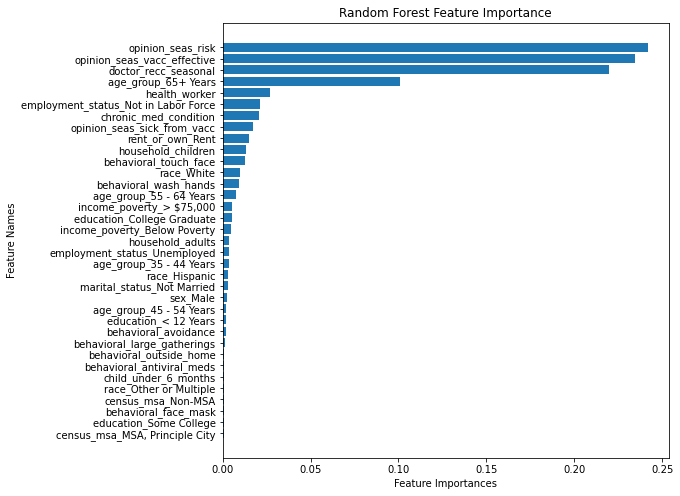

In [47]:
#plot the data
plot_importance(feature_names, rfc_feature_import, "Feature Names", "Feature Importances", 
               "Random Forest Feature Importance")

### XGBoost Model

So far, we've been hovering around 77% for accuracy - lets see if we can improve that by using an XGBoost model.

In [48]:
# create baseline XGB model pipeline
base_XGB_pipe = Pipeline(steps=[("preprocessing_pipe", preprocessing_pipe),
                               ("base_XGB", XGBClassifier(random_state=42,
                                                         use_label_encoder=False))])
# fit to pipeline
base_XGB_pipe.fit(X_train, y_train)

train_pred = base_XGB_pipe.predict(X_train)
test_pred = base_XGB_pipe.predict(X_test)

#find accuracy of test and training sets
training_accuracy = accuracy_score(y_train, train_pred)
test_accuracy = accuracy_score(y_test, test_pred)

print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))


[19:22:51] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Accuracy: 85.99%
Validation accuracy: 77.31%


So the test set is still preforming around 77%, and our model seems a bit overfit to our data - lets try using `GridSearchCV` to find paramenters that will work better. 

In [49]:
# creating the parameters grid
param_grid = {
    'base_XGB__learning_rate': [0.1, 0.2],
    'base_XGB__max_depth': [3, 4],
    'base_XGB__min_child_weight': [2, 3],
    'base_XGB__subsample': [0.6, 0.7],
    'base_XGB__n_estimators': [75, 80],
}

In [50]:
#perform GridSearchCV
grid_XGB = GridSearchCV(estimator=base_XGB_pipe,
                        scoring = "accuracy",
                        param_grid=param_grid,
                        cv=5)
grid_XGB.fit(X_train, y_train)

[19:23:12] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:23:13] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:23:13] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:23:14] WARNING:

[19:23:24] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:23:24] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:23:25] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:23:25] WARNING:

[19:23:36] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:23:37] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:23:37] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:23:38] WARNING:

[19:23:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:23:51] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:23:52] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:23:52] WARNING:

[19:24:03] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:24:04] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:24:04] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:24:05] WARNING:

[19:24:19] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:24:20] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:24:20] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:24:21] WARNING:

[19:24:37] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:24:37] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:24:38] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:24:39] WARNING:

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing_pipe',
                                        Pipeline(steps=[('NAN_median',
                                                         FunctionTransformer(func=<function replace_NAN_median at 0x000001559F5B0DC0>)),
                                                        ('NAN_mode',
                                                         FunctionTransformer(func=<function replace_NAN_mode at 0x000001559F5B08B0>)),
                                                        ('NAN_0',
                                                         FunctionTransformer(func=<function replace_NAN_0 at 0x000001559F5B0B80>)),
                                                        ('col_transf...
                                                      random_state=42,
                                                      reg_alpha=0, reg_lambda=1,
                                                      scale_pos_weight=1,
           

In [51]:
grid_XGB.best_params_

{'base_XGB__learning_rate': 0.1,
 'base_XGB__max_depth': 3,
 'base_XGB__min_child_weight': 2,
 'base_XGB__n_estimators': 80,
 'base_XGB__subsample': 0.7}

In [52]:
training_preds = grid_XGB.predict(X_train)
test_preds = grid_XGB.predict(X_test)

training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print('')
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))


Training Accuracy: 78.12%
Validation accuracy: 78.58%


In [53]:
#get feature importances
optimized_XGB_pipe = Pipeline(steps=[("preprocessing_pipe", preprocessing_pipe),
                      ("optimized_XGB", XGBClassifier(random_state=42,
                                                      use_label_encoder=False,
                                                      learning_rate =  0.1,
                                                      max_depth = 4,
                                                      min_child_weight = 3,
                                                      n_estimators = 75,
                                                      subsample = 0.7))])
optimized_XGB_pipe.fit(X_train, y_train)

# https://9to5answer.com/feature-importance-with-xgbclassifier
xgb_fea_imp=pd.DataFrame(list(optimized_XGB_pipe[1].get_booster().get_fscore().items()))
#https://stackoverflow.com/questions/54933804/how-to-restore-the-original-feature-names-in-xgboost-feature-importance-plot-af

[19:25:48] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


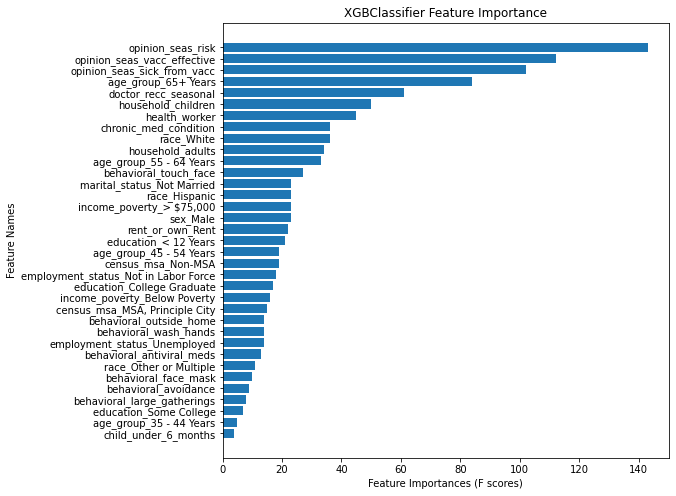

In [54]:
#plot the data -ASK FAITH
#xgb_fea_names = pd.DataFrame(list(optimized_XGB_pipe[1].get_booster().feature_names))
plot_importance(feature_names[:], xgb_fea_imp[1], "Feature Names", "Feature Importances (F scores)", 
                "XGBClassifier Feature Importance")